## Notebook for 1D BDT scan and calculating FOMs in Bd2psi2SKS on data


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/chasenberg/repos/')
import os
import sys
import ROOT
from ROOT import TFile, TH1D, TH2D, TCanvas, gStyle, TLine, TTree
from ROOT import (RooArgSet, RooRealVar, RooDataSet, RooPlot, RooFit, RooStats, RooArgList)
import root_pandas as rp
import root_numpy as ry 

import math
import itertools
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from root_pandas import read_root
import pandas as pd

sys.path.append('/home/vmueller/repos')
from dopy.doroot.root_utils import read_roodataset_from_tree, plot_pulls
from dopy.doplot.plotting import Plotter, Plot                

In [2]:

from ROOT import RooRealVar, RooExponential, RooExtendPdf, RooAddPdf, RooArgList, RooGaussian
from ROOT import RooFormulaVar
from ROOT import gSystem
gSystem.Load('libRooFit.so')
gSystem.Load('/home/chasenberg/repos/dopy/dolib/CustomShapes/libKll')
from ROOT import RooIpatia2

### Read ROOT file

In [3]:
dataset_file_name = '/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/Bd2JpsiKS_pv_selected.root'

In [4]:
branches = [
            'B0_TAGOMEGA_OS',
            'B0_TAGDECISION_OS',
            'B0_FitPVConst_tau_flat',
            'B0_FitPVConst_tauErr_flat',
            'B0_TRUETAU',
            'B0_FitPVConst_MinIPCHI2anyPV_flat',
            'idxRunNumber',
            'idxEventNumber',
            'idxPV',
            'Delta_TAU',
            'BDTresponse_wrongPV'
            ]


In [5]:
tree_mc = 'Bd2JpsiKS'
signal_dataframe_wrongPV  = rp.read_root(dataset_file_name,key=tree_mc,columns=branches, flatten=False)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.replace([np.inf, -np.inf], np.nan)
signal_dataframe_wrongPV  = signal_dataframe_wrongPV.dropna()

In [6]:
signal_dataframe_wrongPV.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key='Bd2JpsiKS')

In [7]:
# Read data and fit it
dataset_file_name = '/fhgfs/users/chasenberg/data/2015_2016_merged/jpsimumuks/interim.root'
data = ROOT.TFile(dataset_file_name)
dataset_tree = data.Get('Bd2JpsiKS') 
dataset_tree.GetEntries()



203016

In [8]:
signal_dataframe_wrongPV['BDTresponse_wrongPV'].max()

6.1676589792857133

### Function to calculate the FOMs

### Configure  and define cuts 

In [9]:
lowerbound=5220 # rather arbitrary signal window definition
upperbound=5450
#B0_FitDaughtersConst_M.setRange('SIGREGION',lowerbound,upperbound)

subdir = '/home/chasenberg/plots/wrongpv_cuttuning'
plot_dir    = os.path.join(subdir, 'plots')
results_dir = os.path.join(subdir, 'results')
plot_file   = os.path.join(plot_dir, 'all_plots.pdf')


if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

cuttype = 'BDTresponse_wrongPV' 

minimum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].min()
maximum = signal_dataframe_wrongPV['BDTresponse_wrongPV'].max()
cuts = np.linspace(minimum,5.5,40) #(0,20,10)    #(0,0.001,10)
#cuts = [-0.05]
cuts_for_which_to_store_sdata = []   

num_sig = []
num_bkg = []
num_all = []

cut_to_performance = {} 
cut_to_shape = {}

perform_fit = True
do_splot    = True
postfix = ''
final_params_file = None
oldParameters = None
final_model = None

### Calculate FOM

In [10]:
def calculate_foms(data_fit_cut): 
    import math
    
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    signal_sum    = 0
    cbkg_sum      = 0
    signal_sumw2  = 0
    timeres_power = 0
    tagging_power = 0
    
    signal_sum_tag_decis = 0 # count two ways to check consistency
    signal_sum_tag_omega = 0
    
    delta_m = 5065 
    S = 0.691 #sin2beta value (average from HFAG)

    
    tagomega = np.array(data_fit_cut['B0_TAGOMEGA_OS'])
    tag1 = np.array(data_fit_cut['B0_TAGDECISION_OS'])
    time = np.array(data_fit_cut['B0_FitPVConst_tau_flat']) 
    error = np.absolute(np.array(data_fit_cut['Delta_TAU'])) 
    

    ##################################################################
    
    for i in range(data_fit_cut.shape[0]):
        signal_weight =  1 
        cbkg_weight   =  1 
        mistag        =  tagomega[i] 
        tag           =  tag1[i]
        decaytime     =  time[i]
        timeerror     =  error[i]
        
        
        signal_sum    += signal_weight
        signal_sumw2  += signal_weight**2
        
        timeerror_dilution = math.exp(-(delta_m*timeerror)**2)
    
        timeres_power     += timeerror_dilution *signal_weight 
        
        timeres_power /= signal_sum  
        
    tagging_power /= signal_sum
    timeres_power /= signal_sum

    
    
    fomname_to_value = {
    
        'TimeresPower' : timeres_power,
        'Efficiency'   : efficiency
    }

    return fomname_to_value

(array([  7.36800000e+03,   9.00700000e+03,   1.55730000e+04,
          9.08600000e+03,   1.17790000e+04,   8.17300000e+03,
          1.02470000e+04,   7.91000000e+03,   9.65200000e+03,
          1.44480000e+04,   1.43130000e+04,   1.28910000e+04,
          1.66410000e+04,   3.85620000e+04,   8.57530000e+04,
          1.19569000e+05,   4.44330000e+04,   1.66430000e+04,
          1.05000000e+02,   4.50000000e+01]),
 array([ 4.00001767,  4.10839973,  4.2167818 ,  4.32516386,  4.43354593,
         4.54192799,  4.65031006,  4.75869213,  4.86707419,  4.97545626,
         5.08383832,  5.19222039,  5.30060245,  5.40898452,  5.51736659,
         5.62574865,  5.73413072,  5.84251278,  5.95089485,  6.05927691,
         6.16765898]),
 <a list of 20 Patch objects>)

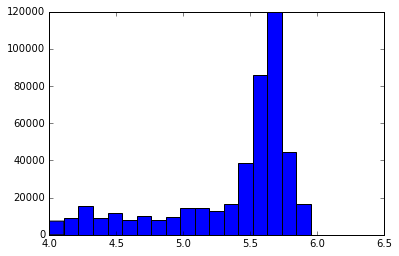

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.hist(signal_dataframe_wrongPV['BDTresponse_wrongPV'],20)

In [12]:
import numpy as np

def unpack_cut_dict(cut_dict, normalize=True):
    cuts = np.array(list(cut_dict.keys()))
    cuts.sort()
    
    new_dict = {}
    for cut in cuts:
        parameters_dict = cut_dict[cut]
        for parameter, value in parameters_dict.items():
            if parameter in new_dict:
                new_dict[parameter].append(value)
            else:
                new_dict[parameter] = [value]
    
    for parameter, values in new_dict.items():
        new_dict[parameter] = np.array(values)
        if normalize:
            new_dict[parameter] = values/np.max(np.abs(values))
    
    return cuts, new_dict

x, ys = unpack_cut_dict(cut_to_performance)
for parameter, values in ys.items():
    if "value" in parameter:
        print(values)
        y_errlo = np.array(ys[parameter.replace("_value","_errlo")])
        y_errhi = np.array(ys[parameter.replace("_value","_errhi")])
        y_errors= abs(np.vstack([y_errlo,y_errhi]))
        plt.errorbar(x,values,yerr=y_errors,marker='.',linestyle='', label='sigma')
        plt.xlabel(parameter)
        plotname = parameter + '.pdf'
        singleplot_file = os.path.join(plot_dir, plotname)
        plt.savefig(singleplot_file)
        plt.show()

In [13]:
first_cut = str(cuts[0])
print(first_cut)

4.0000176653


In [14]:
from ROOT import RooArgList
import subprocess, os
import time
import root_pandas as rp

x=None




first_cut = str(cuts[0])
data_fit_cut = signal_dataframe_wrongPV#.query('BDTresponse_wrongPV>='+ first_cut)
my_env = os.environ.copy()
my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
        'lb-run DaVinci/v41r2 $BASH -c "' \
        'echo $PATH && ' \
        'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'        
subprocess.Popen([my_command], env=my_env, shell=True)
        
print("Wait for GrimReaper")
time.sleep(40.0)        # pause 5.5 seconds
print("GrimReaper hopefully finished")
print('INFO: Read selected data', flush=True)
data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
sig_yields_init = data_fit_cut.shape[0]

for cut in cuts:
    print('INFO: Starting to test cut ' + '{0}>{1}'.format(cuttype,cut), flush=True)
    data_fit_cut = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)) #data_after_import.reduce('{0}>{1}'.format(cuttype,cut))
    #best_pv = signal_dataframe_wrongPV.query('{0}>{1}'.format(cuttype,cut)).query('idxPV==0')
    #data_fit_cut = data_fit_cut.query('B0_FitPVConst_MinIPCHI2anyPV_flat>6')
    #print("The size of the sample is:")
    #print(data_fit_cut['Delta_TAU'].min())
    data_fit_cut.to_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    print('INFO: Call CandidateSelectionGrimReaper', flush=True)
    my_env = os.environ.copy()
    my_env['PATH'] = '/usr/local/bin:/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/sbin:/home/chasenberg/bin'
    my_env['LD_LIBRARY_PATH'] = '/usr/local/lib'
    my_env['script'] = '/home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection'
    my_command = 'source /lhcbsoft/LHCbSoftwareSetup.sh &&' \
             'lb-run DaVinci/v41r2 $BASH -c "' \
             'echo $PATH && ' \
             'source /doosoft/InstallDooSoftware/LoadDooSoftware && CandidateSelectionGrimReaper /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS /fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root Bd2JpsiKS "idxRunNumber""'                     
    subprocess.Popen([my_command], env=my_env, shell=True)
   # subprocess.call(('bash /home/chasenberg/repos/b2cc_sin2beta_run2/notebooks/selection/random_sel.sh'),shell=True)                      
    print("Wait for GrimReaper")
    time.sleep(40.0)    # pause 5.5 seconds
    print("GrimReaper hopefully finished")
    print('INFO: Read selected data', flush=True)
    data_fit_cut = rp.read_root('/fhgfs/users/chasenberg/mc/2015_2016_merged/jpsimumuks/interim.root',key=tree_mc)
    
    print('INFO: Start Calculation', flush=True)
    #print('INFO: Building Ipatia (signal) + Exp (combinatorics) + Ipatia (bs-component) model for data', flush=True) 
    #final_model = build_mass_model(B0_FitDaughtersConst_M)
    sig_yields_cut = data_fit_cut.shape[0] 
    efficiency = sig_yields_cut / sig_yields_init
    print("The inital number of candidates is:")
    print(sig_yields_init)
    print("----------------------------------")
    print("The number of candidates after the cut is:")
    print(sig_yields_cut)
    print("----------------------------------")
    print("The efficiency of the cut is:")
    print(efficiency)
    cut_to_shape[cut] = {} 
    cut_to_performance[cut] = {}
    
    
    foms = calculate_foms(data_fit_cut)
    cut_to_performance[cut].update(foms)
    
    print('INFO: Finish Calculation', flush=True)

Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Starting to test cut BDTresponse_wrongPV>4.00001766529743
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
452198
----------------------------------
The number of candidates after the cut is:
452197
----------------------------------
The efficiency of the cut is:
0.9999977885793392
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrongPV>4.038478750802624
INFO: Call CandidateSelectionGrimReaper
Wait for GrimReaper
GrimReaper hopefully finished
INFO: Read selected data
INFO: Start Calculation
The inital number of candidates is:
452198
----------------------------------
The number of candidates after the cut is:
450814
----------------------------------
The efficiency of the cut is:
0.9969393938053684
INFO: Finish Calculation
INFO: Starting to test cut BDTresponse_wrong

### Plot FOMs

In [15]:
'''import random
import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("whitegrid", {"legend.frameon": True})

x, ys = unpack_cut_dict(cut_to_performance)
shift = 0.0

foms_to_plot = {}
foms_to_plot["TimeresPower"] = "BDT PV selection"

#for parameter, values in ys.items():
for parameter in foms_to_plot:
    x=ys[parameter]
    values = ys['TimeresPower']
    #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter\
    #or "TaggingPower" in parameter or "TimeresPower" in parameter:
    if parameter in foms_to_plot:
        plt.errorbar(x,values+random.random()*shift,marker='.',linestyle='-',label=foms_to_plot[parameter])
        plt.xlabel("wPV BDT cut")

plt.gca().set_ylim(0.,1.0)
plt.gca().set_xlim(4,6.5)
plt.legend(loc='best')
plt.savefig(subdir + '/FOMS.pdf')
plt.show()'''

'import random\nimport seaborn as sns\nsns.set_style("whitegrid")\nsns.set_style("whitegrid", {"legend.frameon": True})\n\nx, ys = unpack_cut_dict(cut_to_performance)\nshift = 0.0\n\nfoms_to_plot = {}\nfoms_to_plot["TimeresPower"] = "BDT PV selection"\n\n#for parameter, values in ys.items():\nfor parameter in foms_to_plot:\n    x=ys[parameter]\n    values = ys[\'TimeresPower\']\n    #if "FOM" in parameter or "EffSig" in parameter or "s3_over_spb2" in parameter    #or "TaggingPower" in parameter or "TimeresPower" in parameter:\n    if parameter in foms_to_plot:\n        plt.errorbar(x,values+random.random()*shift,marker=\'.\',linestyle=\'-\',label=foms_to_plot[parameter])\n        plt.xlabel("wPV BDT cut")\n\nplt.gca().set_ylim(0.,1.0)\nplt.gca().set_xlim(4,6.5)\nplt.legend(loc=\'best\')\nplt.savefig(subdir + \'/FOMS.pdf\')\nplt.show()'

(40, 2)


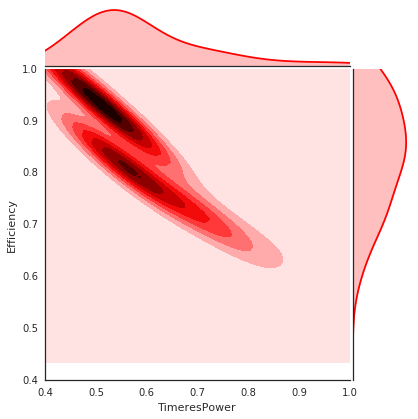

In [16]:
import seaborn as sns; sns.set_style('white')

x, ys = unpack_cut_dict(cut_to_performance)
test = pd.DataFrame()
test['TimeresPower'] = np.array(ys['TimeresPower'])
test['Efficiency'] = np.array(ys['Efficiency'])


y_lim = (0.4,1)
x_lim = (0.4,1)
g = sns.jointplot(x='TimeresPower', y='Efficiency',data=test,stat_func=None,space=0.05, kind="kde",xlim=x_lim,ylim=y_lim, color="r")
#g.savefig("/home/chasenberg/plots/wrong_pv/deltatau_vs_pvzpull.pdf")
print(test.shape)

(0.4, 1.05)

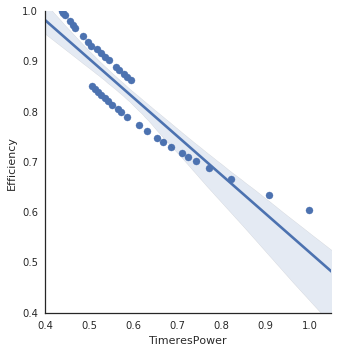

In [17]:
x = test['TimeresPower'] = np.array(ys['TimeresPower'])
y = test['Efficiency'] = np.array(ys['Efficiency'])
lm = sns.lmplot(x='TimeresPower', y='Efficiency',data=test,x_estimator=np.mean)
axes = lm.axes
axes[0,0].set_ylim(0.4,1)
axes[0,0].set_xlim(0.4,1.05)

In [18]:
ys['TimeresPower']

array([ 0.43874368,  0.44143976,  0.44540861,  0.45664691,  0.46397023,
        0.46856216,  0.48490732,  0.49684542,  0.50510349,  0.51773783,
        0.52758978,  0.53527759,  0.54446365,  0.55997191,  0.56810222,
        0.57813829,  0.58622452,  0.59583856,  0.5053065 ,  0.51237121,
        0.52041282,  0.52694686,  0.53549294,  0.5417858 ,  0.55228043,
        0.56519425,  0.57250699,  0.58637818,  0.61190021,  0.63152498,
        0.65314969,  0.66860854,  0.68541428,  0.71015801,  0.72539812,
        0.74290475,  0.77287424,  0.82255038,  0.90750016,  1.        ])

[]

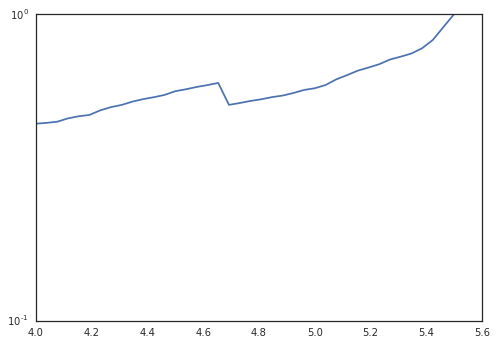

In [19]:
a = test['TimeresPower']
plt.plot(cuts,a)
plt.semilogy()

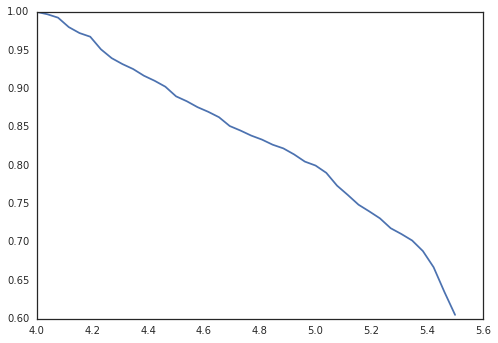

In [20]:
a = test['Efficiency']
plt.plot(cuts,a)


In [21]:
a

0     1.000000
1     0.996942
2     0.992490
3     0.980201
4     0.972435
5     0.967658
6     0.951209
7     0.939712
8     0.931999
9     0.925519
10    0.916837
11    0.910229
12    0.902518
13    0.889933
14    0.883542
15    0.875840
16    0.869778
17    0.862732
18    0.851255
19    0.845366
20    0.838809
21    0.833592
22    0.826914
23    0.822097
24    0.814249
25    0.804893
26    0.799736
27    0.790220
28    0.773566
29    0.761451
30    0.748740
31    0.740034
32    0.730905
33    0.718059
34    0.710476
35    0.702055
36    0.688308
37    0.667200
38    0.635205
39    0.605115
Name: Efficiency, dtype: float64

In [22]:
x

array([ 0.43874368,  0.44143976,  0.44540861,  0.45664691,  0.46397023,
        0.46856216,  0.48490732,  0.49684542,  0.50510349,  0.51773783,
        0.52758978,  0.53527759,  0.54446365,  0.55997191,  0.56810222,
        0.57813829,  0.58622452,  0.59583856,  0.5053065 ,  0.51237121,
        0.52041282,  0.52694686,  0.53549294,  0.5417858 ,  0.55228043,
        0.56519425,  0.57250699,  0.58637818,  0.61190021,  0.63152498,
        0.65314969,  0.66860854,  0.68541428,  0.71015801,  0.72539812,
        0.74290475,  0.77287424,  0.82255038,  0.90750016,  1.        ])